In [1]:
import sys
sys.path.append('../../..')
from contrib.DMI.ASIP_OSISAF.data import *
from contrib.DMI.ASIP_OSISAF.load_data import *
from src.utils import *
from src.models import *

import matplotlib.pyplot as plt
import torch
import itertools


datamodule = BaseDataModule(asip_paths=load_data(),
                            osisaf_paths=load_data(type="osisaf"),
                            domains={'train': {'time': slice('2022-01-01', '2023-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-06-30',),
                                                       slice('2021-07-01', '2021-12-31',) ]},
                                     'test': {'time': slice('2024-01-01', '2024-01-20',)}},
                            xrds_kw={'patch_dims': {'time': 19, 'yc': 240, 'xc': 240},
                                     'strides': {'time': 1, 'yc': 20, 'xc': 20},
                                     'strides_test': {'time': 1, 'yc': 200, 'xc': 200},
                                     'domain_limits':  dict(xc=slice(-3849750.,3749750.,),
                                                            yc=slice(5849750.,-5349750.,))
                                     },
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            res=500,
                            pads=[False,False,True],
                            norm_stats =[0,1])
datamodule.setup()

data_loader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

#k=10
#my_sample = next(itertools.islice(data_loader, k, None))
#print(my_sample[0].shape)

/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


{'time': 729, 'xc': 15200, 'yc': 22400}
{'time': 180, 'xc': 15200, 'yc': 22400}
{'time': 183, 'xc': 15200, 'yc': 22400}
{'time': 19, 'xc': 15240, 'yc': 22440}


In [4]:
lon = xr.open_dataset(datamodule.train_ds.asip_paths[0]).lon.values
lat = xr.open_dataset(datamodule.train_ds.asip_paths[0]).lat.values
xc = xr.open_dataset(datamodule.train_ds.asip_paths[0]).xc.values
yc = xr.open_dataset(datamodule.train_ds.asip_paths[0]).yc.values
def find_idx(coords,c):
    return np.where(coords==c)[0][0]

In [3]:
coords = datamodule.train_ds.get_coords()

lon = xr.open_dataset(datamodule.train_ds.asip_paths[0]).lon.values
lat = xr.open_dataset(datamodule.train_ds.asip_paths[0]).lat.values
xc = xr.open_dataset(datamodule.train_ds.asip_paths[0]).xc.values
yc = xr.open_dataset(datamodule.train_ds.asip_paths[0]).yc.values

k = 1
data = datamodule.train_ds[k]

ix = [find_idx(xc,x) for x in coords[k].xc.values]
iy = [find_idx(yc,y) for y in coords[k].yc.values]

ds = xr.Dataset(data_vars={'sic':(('time','yc','xc'),data.coarse)},
               coords={'time':np.arange(19),
                   'lon':(["yc","xc"], lon[iy[0]:(iy[-1]+1),ix[0]:(ix[-1]+1)]),
                   'lat':(["yc","xc"], lat[iy[0]:(iy[-1]+1),ix[0]:(ix[-1]+1)])})

p = ds.sic.plot(transform=ccrs.PlateCarree(),
                col='time',col_wrap=19,
                #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'],
                subplot_kws={'projection': ccrs.NorthPolarStereo()})
"""
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    ax.gridlines()
    ax.set_extent([np.min(ds.lon.values),
                   np.max(ds.lon.values),
                   np.min(ds.lat.values),
                   np.max(ds.lat.values)], crs=ccrs.PlateCarree())
"""

<xarray.Dataset> Size: 33MB
Dimensions:                 (time: 19, yc: 240, xc: 240)
Coordinates:
  * time                    (time) datetime64[ns] 152B 2022-01-01T20:16:00 .....
  * xc                      (xc) float64 2kB -3.84e+06 -3.839e+06 ... -3.72e+06
  * yc                      (yc) float64 2kB 5.85e+06 5.849e+06 ... 5.73e+06
    lat                     (yc, xc) float32 230kB 31.02 31.02 ... 32.19 32.19
    lon                     (yc, xc) float32 230kB 168.3 168.3 ... 168.0 168.0
Data variables:
    crs                     (time) float32 76B 9.969e+36 9.969e+36 ... 9.969e+36
    acq_time                (time, yc, xc) float32 4MB nan nan nan ... nan nan
    sic                     (time, yc, xc) float32 4MB nan nan nan ... nan nan
    sod                     (time, yc, xc) float32 4MB nan nan nan ... nan nan
    flz                     (time, yc, xc) float32 4MB nan nan nan ... nan nan
    standard_deviation_sic  (time, yc, xc) float32 4MB nan nan nan ... nan nan
    confidence

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f8ffc79c400> (for post_execute), with arguments args (),kwargs {}:


Traceback (most recent call last):
  File "/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/IPython/core/events.py", line 82, in trigger
    func(*args, **kwargs)
  File "/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/matplotlib/pyplot.py", line 268, in _draw_all_if_interactive
    draw_all()
  File "/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/matplotlib/_pylab_helpers.py", line 131, in draw_all
    manager.canvas.draw_idle()
  File "/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1905, in draw_idle
    self.draw(*args, **kwargs)
  File "/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/matplotlib/backends/backend_agg.py", line 387, in draw
    self.figure.draw(self.renderer)
  File "/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/matplotlib/artist.

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f8fdcf976a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

# 1. Display the patch strategy

## 1.1 Plot the training batches

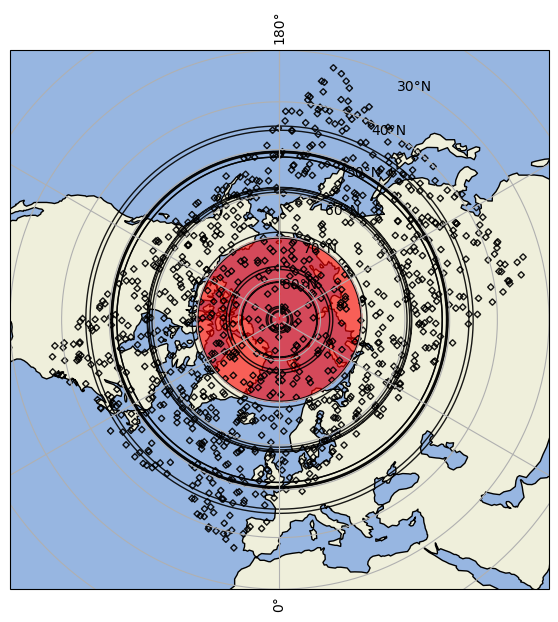

In [6]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.NorthPolarStereo()
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

coords = datamodule.train_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[-180, 70], width=360, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.6,
                                    facecolor="red",
                                    transform=ccrs.PlateCarree()))

for k in sample(range(0,10000),1000):
    nxc = len(coords[k].xc.values)
    nyc = len(coords[k].yc.values)
    x = np.hstack((coords[k].xc.values,
                   np.repeat(coords[k].xc.values[-1],nyc),
                   np.flip(coords[k].xc.values),
                   np.repeat(coords[k].xc.values[0],nyc)))
    y = np.hstack((np.repeat(coords[k].yc.values[0],nxc),
                   coords[k].yc.values,
                   np.repeat(coords[k].yc.values[-1],nxc),
                   np.flip(coords[k].yc.values)))
    xy = np.vstack((x,y)).T
    klon = lon[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
    klat = lat[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
    lonlat = np.vstack((klon,klat)).T
    ax.add_patch(mpatches.Polygon(xy=lonlat, 
                                  closed=True,
                                  edgecolor='black',
                                  facecolor="none",
                                  alpha=0.9,
                                  transform=ccrs.PlateCarree()))      
plt.show()

## 1.2 Plot the testing batches

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
padded patch
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
padded patch
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
padded patch
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267

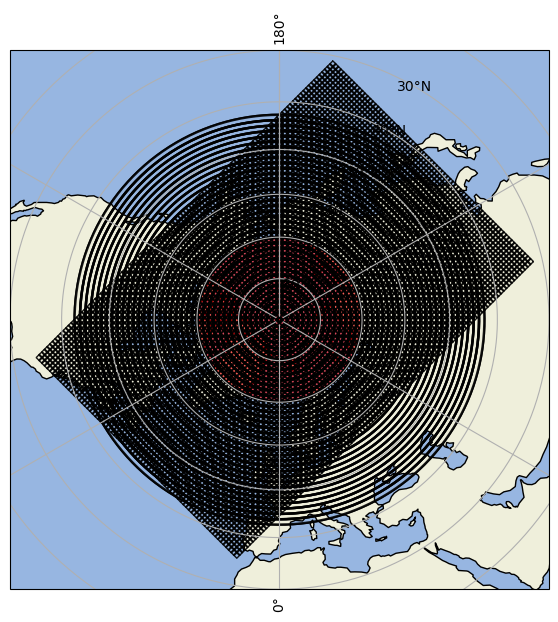

In [11]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.NorthPolarStereo()
map_proj._threshold /= 100.

xc = datamodule.test_ds.xc
yc = datamodule.test_ds.yc

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[-180, 70], width=360, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.6,
                                    facecolor="red",
                                    transform=ccrs.PlateCarree()))

for k in range(len(coords)):
    nxc = len(coords[k].xc.values)
    nyc = len(coords[k].yc.values)
    x = np.hstack((coords[k].xc.values,
                   np.repeat(coords[k].xc.values[-1],nyc),
                   np.flip(coords[k].xc.values),
                   np.repeat(coords[k].xc.values[0],nyc)))
    y = np.hstack((np.repeat(coords[k].yc.values[0],nxc),
                   coords[k].yc.values,
                   np.repeat(coords[k].yc.values[-1],nxc),
                   np.flip(coords[k].yc.values)))
    xy = np.vstack((x,y)).T
    try:
        klon = lon[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
        klat = lat[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
        lonlat = np.vstack((klon,klat)).T
        ax.add_patch(mpatches.Polygon(xy=lonlat, 
                                  closed=True,
                                  edgecolor='black',
                                  facecolor="none",
                                  alpha=0.9,
                                  transform=ccrs.PlateCarree())) 
    except:
        print("padded patch")
plt.show()

# 2. Load the model and run

In [12]:
device = 'cuda'
from contrib.DMI.ASIP_OSISAF.solver import *
from contrib.DMI.ASIP_OSISAF.UNet import *

solver = GradSolver(n_step=15,
                     lr_grad=1e3,
                      prior_cost = SRNNPriorCost(srnn=UNet(in_channels=19,
                                                      num_classes=19)),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=19,dim_hidden=96)).to(device)

/dmidata/users/maxb/4dvarnet-starter/Notebooks/Notebook_DMI/ASIP_OSISAF/../../../contrib/DMI/ASIP_OSISAF/UNet.py:210: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/dmidata/users/maxb/4dvarnet-starter/Notebooks/Notebook_DMI/ASIP_OSISAF/../../../contrib/DMI/ASIP_OSISAF/UNet.py:211: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


## 2.1 Define the parameters

In [8]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)


def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    prior_cost = solver.prior_cost(solver.init_state(batch, out))
    training_loss = 50*loss  + 10000 * grad_loss + 10 * prior_cost
    print(50*loss, 10000 * grad_loss, 10 * prior_cost)
    
    return training_loss, out

def base_step(batch):

    out = solver(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [9]:
#ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/DMI/SST/sst_dmi_all_baltic_wgeo_linweight.ckpt', map_location=device)
ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/DMI/SST/sst_dmi_baltic_dm3.ckpt', map_location=device)
solver_weights = {k[7:]: v for k, v in ckpt["state_dict"].items() if k.startswith("solver.")}
solver.load_state_dict(solver_weights)

<All keys matched successfully>

In [10]:
k=56
test_batch = next(itertools.islice(test_dataloader, k, None))
test_batch_ = test_batch
test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
"""
test_batch_ = test_batch_._replace(lat=test_batch_.lat.nan_to_num().to(device))
test_batch_ = test_batch_._replace(lon=test_batch_.lon.nan_to_num().to(device))
test_batch_ = test_batch_._replace(mask=test_batch_.mask.nan_to_num().to(device))
"""
# 4DVarNets scheme  
out = solver(test_batch_)

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/torch/autograd/__init__.py:276: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/tmp/ipykernel_2930312/1445816560.py:17: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_2930312/1445816560.py:24: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


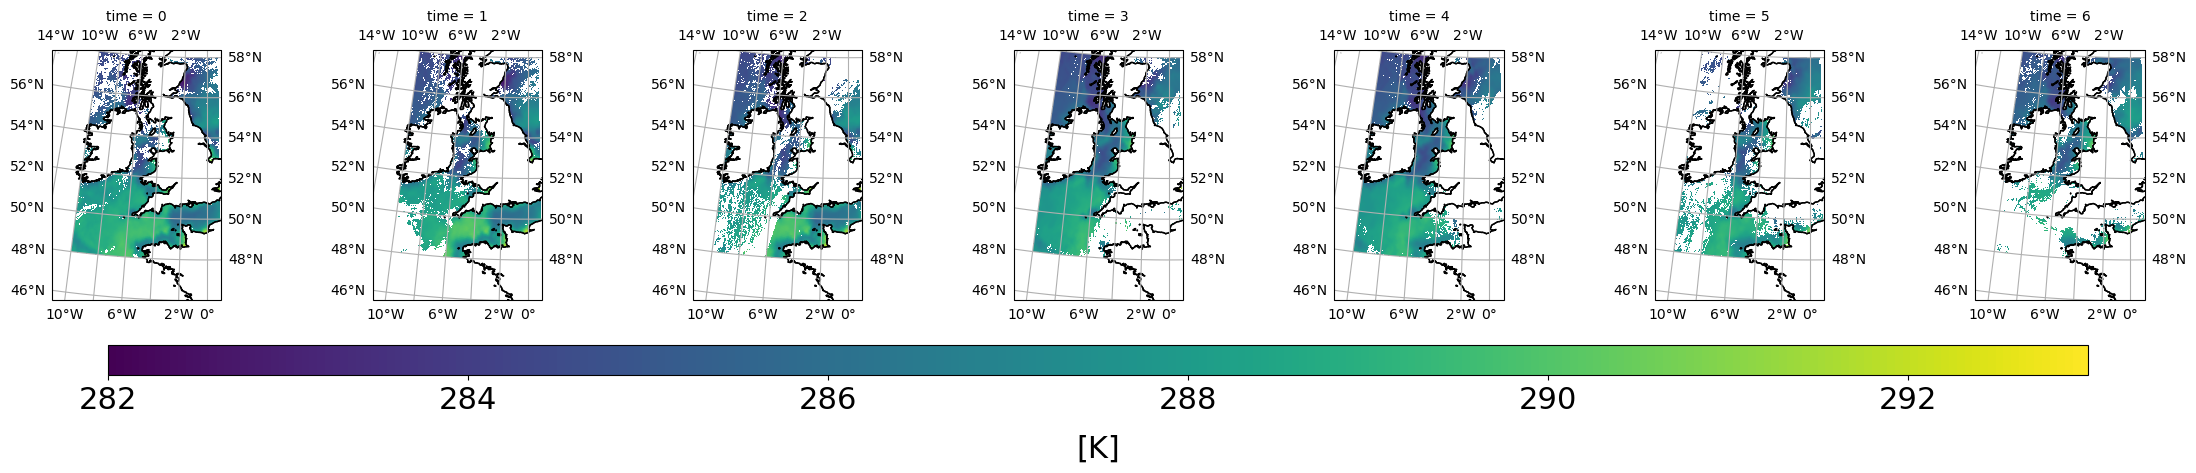

In [11]:
coords = datamodule.test_ds.get_coords()
m, s = [283.8052,4.2381434]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
# datamodule.train_ds[0].input has shape (15, 240, 240)
#plt.figure(figsize=(30,20))
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),test_batch.input[0,:,:,:].detach().cpu().numpy()*s+m)},
           coords={'time':np.arange(7),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=282, vmax=293,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

plt.subplots_adjust(wspace=.3)
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())